<img SRC="https://avatars2.githubusercontent.com/u/31697400?s=400&u=a5a6fc31ec93c07853dd53835936fd90c44f7483&v=4" WIDTH=125 ALIGN="right">

# Combining and splitting model layers

*D.A. Brakenhoff, Artesia, 2021*

This notebook shows methods for combining layers and splitting layers for MODFLOW models. Multiple layers can be combined into one layer or one layer can be split into sub-layers based on a fraction of the original thickness.


### Contents<a name="TOC"></a>
1. [Get data](#getdata)
2. [Split layers](#splitlayers)
3. [Combine layers](#combinelayers)

In [1]:
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
from shapely.geometry import LineString

import nlmod
from art_tools import DatasetCrossSection

## [1. Get data](#TOC)<a name="getdata"></a>

Define an extent to obtain REGIS

In [2]:
extent = [131000, 136800, 471500, 475700]
extent, nrow, ncol = nlmod.read.regis.fit_extent_to_regis(extent, delr=100, delc=100)
print(f"Updated extent: {extent}")

Updated extent: [131000, 136800, 471500, 475700]


Download and cache REGIS netCDF.

In [3]:
ds = nlmod.read.regis.get_regis_dataset(extent, delr=100, delc=100,
                                        cachedir="./model4", use_cache=True, 
                                        verbose=True)

resample regis data to structured modelgrid


Drop all non-existent layers in our area of interest.

In [4]:
nlay, lay_sel = nlmod.read.regis.get_non_nan_layers(ds)
ds = ds.sel(layer=lay_sel)

Let's take a look at the dataset

In [5]:
ds

<xarray.Dataset>
Dimensions:  (layer: 34, x: 58, y: 42)
Coordinates:
  * y        (y) float64 4.756e+05 4.756e+05 4.754e+05 ... 4.716e+05 4.716e+05
  * x        (x) float64 1.310e+05 1.312e+05 1.312e+05 ... 1.366e+05 1.368e+05
  * layer    (layer) <U64 'HLc' 'BXz2' 'BXz3' 'BXz4' ... 'OOz2' 'OOc' 'BRk1'
Data variables:
    top      (layer, y, x) float64 -1.35 -1.34 -1.37 ... -373.1 -373.0 -372.9
    bot      (layer, y, x) float64 -5.54 -5.53 -5.52 ... -659.3 -659.1 -659.3
    kD       (layer, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    c        (layer, y, x) float64 nan nan nan ... 1.431e+05 1.431e+05 1.432e+05
    kh       (layer, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    kv       (layer, y, x) float64 nan nan nan nan ... 0.002 0.002 0.002 0.002
Attributes:
    extent:    [131000, 136800, 471500, 475700]
    delr:      100
    delc:      100
    gridtype:  structured

Define an line to draw a cross-section

In [6]:
# diagonal line through extent
line = LineString([(extent[0], extent[2]), (extent[1], extent[3])])

Get colors for our cross-section plot.

In [7]:
colors = pd.read_csv("regis_layer_color_codes.csv", index_col=[0])
colors = colors.loc[ds.layer.str.lower()].squeeze().apply(lambda s: eval(s))

Draw the cross-section for REGIS

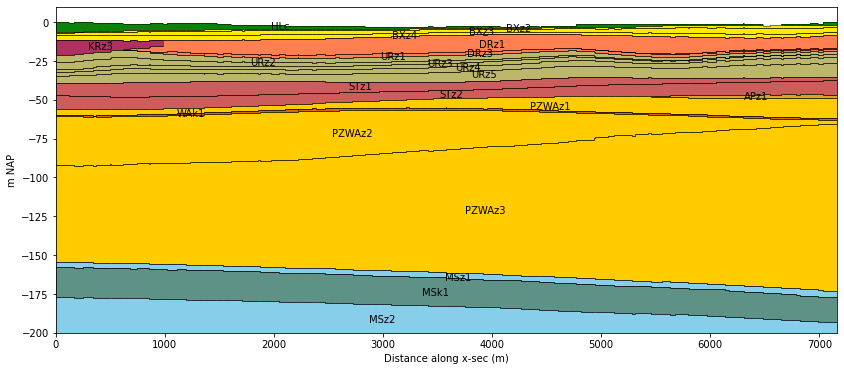

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
dcs = DatasetCrossSection(ds, line=line, top="top", bot="bot", ax=ax, zmin=-200, zmax=10)
dcs.plot_layers(colors=colors, min_label_area=1000)
dcs.plot_grid(linewidth=0.5, vertical=False)
ax.set_ylabel("m NAP")
ax.set_xlabel("Distance along x-sec (m)");

## [2. Split layers](#TOC)<a name="splitlayers"></a>

Define which layers you want to split and determine the indices for those layers

In [9]:
split_layer_codes = ["PZWAz2", "PZWAz3"]
split_lays = np.argwhere(ds.layer.isin(split_layer_codes).data).squeeze()
split_lays

array([19, 20])

Next determine how to split the layers. This is done by creating a list of fractions that must add up to 1. The layer will be split into sub-layers from the top down, with each sub-layer getting a thickness equal to the fraction times the original thickness.

For example, `(0.5, 0.5)` will split the layer into two sub-layers, each getting a thickness equal to 50% of the original layer.

In [10]:
# split dictionary
split_dict = {
    19: (0.3, 0.3, 0.4),
    20: (0.2, 0.2, 0.2, 0.2, 0.2)
}

Calculate the new layer elevations based on the information above. Use the verbose option to pring extra information to the console.

In [11]:
ds_split = nlmod.mdims.mlayers.split_layers_ds(ds, split_dict)

Warning! Following data variables will be dropped: {'c', 'kD'}
Calculating new layer tops and bottoms...
 0: No split: map layer 0 to new layer index 0
 1: No split: map layer 1 to new layer index 1
 2: No split: map layer 2 to new layer index 2
 3: No split: map layer 3 to new layer index 3
 4: No split: map layer 4 to new layer index 4
 5: No split: map layer 5 to new layer index 5
 6: No split: map layer 6 to new layer index 6
 7: No split: map layer 7 to new layer index 7
 8: No split: map layer 8 to new layer index 8
 9: No split: map layer 9 to new layer index 9
10: No split: map layer 10 to new layer index 10
11: No split: map layer 11 to new layer index 11
12: No split: map layer 12 to new layer index 12
13: No split: map layer 13 to new layer index 13
14: No split: map layer 14 to new layer index 14
15: No split: map layer 15 to new layer index 15
16: No split: map layer 16 to new layer index 16
17: No split: map layer 17 to new layer index 17
18: No split: map layer 18 to new

View the resulting Dataset:

In [12]:
ds_split

<xarray.Dataset>
Dimensions:  (layer: 40, x: 58, y: 42)
Coordinates:
  * layer    (layer) <U8 'HLc' 'BXz2' 'BXz3' 'BXz4' ... 'OOz2' 'OOc' 'BRk1'
  * y        (y) float64 4.756e+05 4.756e+05 4.754e+05 ... 4.716e+05 4.716e+05
  * x        (x) float64 1.310e+05 1.312e+05 1.312e+05 ... 1.366e+05 1.368e+05
Data variables:
    top      (layer, y, x) float64 -1.35 -1.34 -1.37 ... -373.1 -373.0 -372.9
    bot      (layer, y, x) float64 -5.54 -5.53 -5.52 ... -659.3 -659.1 -659.3
    kh       (layer, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    kv       (layer, y, x) float64 nan nan nan nan ... 0.002 0.002 0.002 0.002
Attributes:
    extent:           [131000, 136800, 471500, 475700]
    delr:             100
    delc:             100
    gridtype:         structured
    split_reindexer:  OrderedDict([(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5...

The reindexer dictionary we stored links the new layer numbers to the old
layer numbers. This is convenient for copying data from the original layers to the new sub-layers.

In [13]:
# 1st number = new layer index: should number continuously from 1..N
# 2nd number = old layer index: repeats where layer was split
ds_split.attrs["split_reindexer"]

OrderedDict([(0, 0),
             (1, 1),
             (2, 2),
             (3, 3),
             (4, 4),
             (5, 5),
             (6, 6),
             (7, 7),
             (8, 8),
             (9, 9),
             (10, 10),
             (11, 11),
             (12, 12),
             (13, 13),
             (14, 14),
             (15, 15),
             (16, 16),
             (17, 17),
             (18, 18),
             (19, 19),
             (20, 19),
             (21, 19),
             (22, 20),
             (23, 20),
             (24, 20),
             (25, 20),
             (26, 20),
             (27, 21),
             (28, 22),
             (29, 23),
             (30, 24),
             (31, 25),
             (32, 26),
             (33, 27),
             (34, 28),
             (35, 29),
             (36, 30),
             (37, 31),
             (38, 32),
             (39, 33)])

The new layers are named according to the REGIS codes, with an added number if the layer was split into multiple sub-layers. For plotting a cross-section we want to use the original color from the REGIS cross-section plot for the new sub-layers.

In [14]:
layer_names = []
colors_new = {}
for j, i in ds_split.split_reindexer.items():
    layercode = ds.layer.data[i]
    
    if layercode in layer_names:
        layercode += f"_{np.sum([1 for ilay in layer_names if ilay.startswith(layercode)]) + 1}"
    
    layer_names.append(layercode)
    colors_new[layercode] = colors.iloc[i]

colors_new = pd.Series(colors_new)

Plot the cross-section of the original and the new layer model.

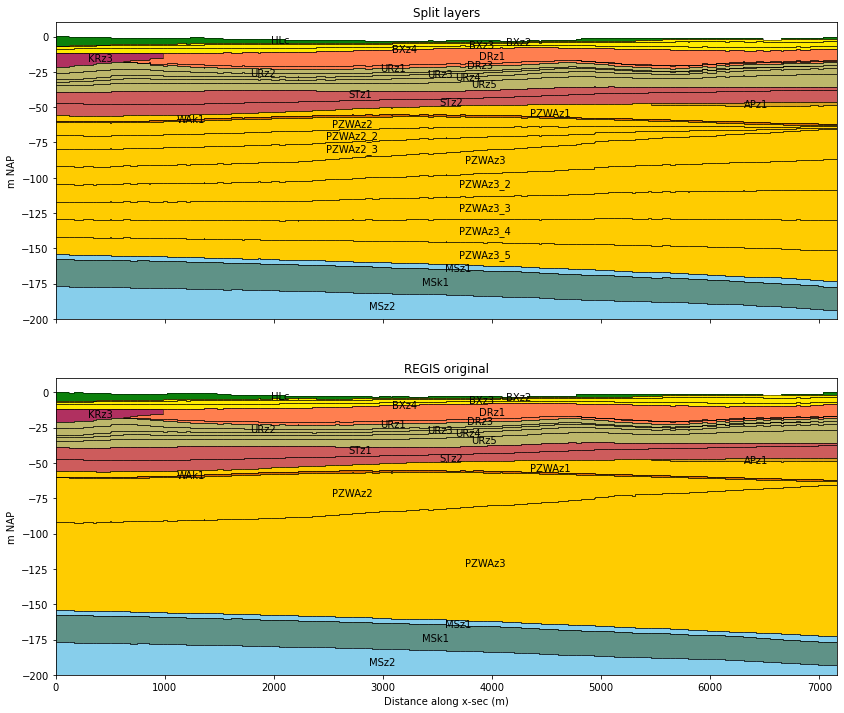

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
dcs2 = DatasetCrossSection(ds_split, line=line, top="top", bot="bot", ax=ax1, zmin=-200, zmax=10)
polys2 = dcs2.plot_layers(colors=colors_new, min_label_area=1000)
dcs2.plot_grid(linewidth=0.5, vertical=False)
ax1.set_ylabel("m NAP")
ax1.set_title("Split layers")

dcs = DatasetCrossSection(ds, line=line, top="top", bot="bot", ax=ax2, zmin=-200, zmax=10)
polys1 = dcs.plot_layers(colors=colors, min_label_area=1000)
dcs.plot_grid(linewidth=0.5, vertical=False)
ax2.set_ylabel("m NAP")
ax2.set_xlabel("Distance along x-sec (m)")
ax2.set_title("REGIS original");

## [3. Combine layers](#TOC)<a name="combinelayers"></a>

Example how to combine model layers. First find the indices of the layers to combine.

In [16]:
combine_layers = [
    tuple(np.argwhere(ds.layer.str.startswith("URz").data).squeeze().tolist()),
    tuple(np.argwhere(ds.layer.isin(["PZWAz2", "PZWAz3"]).data).squeeze().tolist())
]
combine_layers

[(9, 10, 11, 12, 13), (19, 20)]

Combine layers using the `combine_layers_ds()` function and passing the layer dataset and the list of layer numbers to combine.

In [17]:
ds_combine = nlmod.mdims.mlayers.combine_layers_ds(ds, combine_layers)

Calculating new layer tops and bottoms...
 0: Do not merge, map old layer index to new layer index.
 1: Do not merge, map old layer index to new layer index.
 2: Do not merge, map old layer index to new layer index.
 3: Do not merge, map old layer index to new layer index.
 4: Do not merge, map old layer index to new layer index.
 5: Do not merge, map old layer index to new layer index.
 6: Do not merge, map old layer index to new layer index.
 7: Do not merge, map old layer index to new layer index.
 8: Do not merge, map old layer index to new layer index.
 9: Merge layers (9, 10, 11, 12, 13) as layer 9, calculate new top/bot.
10: Do not merge, map old layer index to new layer index.
11: Do not merge, map old layer index to new layer index.
12: Do not merge, map old layer index to new layer index.
13: Do not merge, map old layer index to new layer index.
14: Do not merge, map old layer index to new layer index.
15: Merge layers (19, 20) as layer 15, calculate new top/bot.
16: Do not m

Take a look a the resulting dataset

In [18]:
ds_combine

<xarray.Dataset>
Dimensions:  (layer: 29, x: 58, y: 42)
Coordinates:
  * layer    (layer) <U6 'HLc' 'BXz2' 'BXz3' 'BXz4' ... 'OOz2' 'OOc' 'BRk1'
  * y        (y) float64 4.756e+05 4.756e+05 4.754e+05 ... 4.716e+05 4.716e+05
  * x        (x) float64 1.310e+05 1.312e+05 1.312e+05 ... 1.366e+05 1.368e+05
Data variables:
    top      (layer, y, x) float64 -1.35 -1.34 -1.37 ... -373.1 -373.0 -372.9
    bot      (layer, y, x) float64 -5.54 -5.53 -5.52 ... -659.3 -659.1 -659.3
    kh       (layer, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    kv       (layer, y, x) float64 nan nan nan nan ... 0.002 0.002 0.002 0.002
    kD       (layer, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    c        (layer, y, x) float64 nan nan nan ... 1.431e+05 1.431e+05 1.432e+05
Attributes:
    extent:             [131000, 136800, 471500, 475700]
    delr:               100
    delc:               100
    gridtype:           structured
    combine_reindexer:  OrderedDict([(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), ...

Get layer names and colors (use layer code and color from first layer name for the combined layer).

In [19]:
colors_new = {}
for j, i in ds_combine.combine_reindexer.items():
    if isinstance(i, tuple):
        i = i[0]
    layercode = ds.layer.data[i]    
    colors_new[layercode] = colors.iloc[i]

colors_new = pd.Series(colors_new)

Plot the new and the old cross-section.

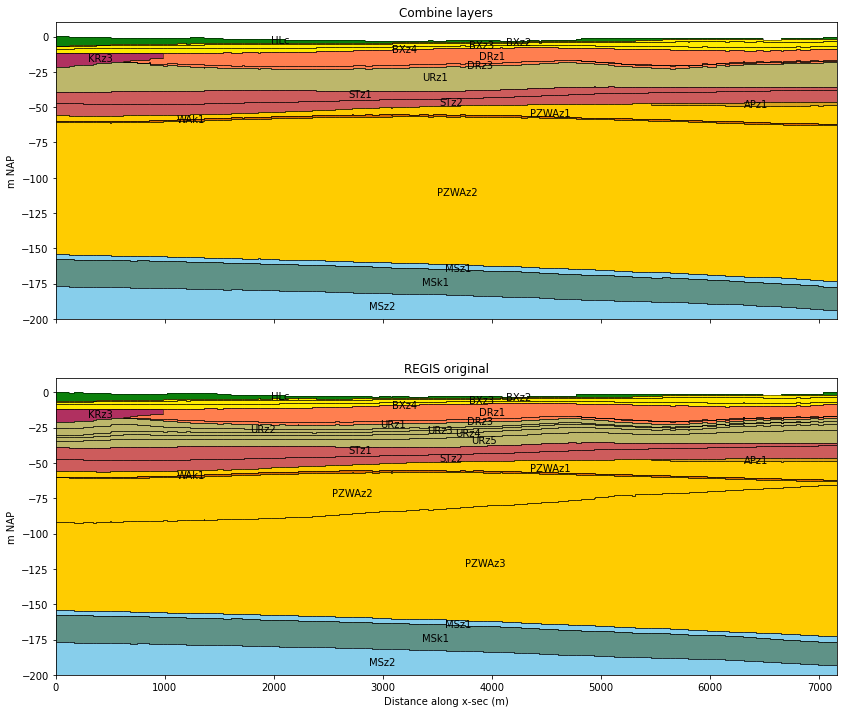

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
dcs2 = DatasetCrossSection(ds_combine, line=line, top="top", bot="bot", ax=ax1, zmin=-200, zmax=10)
polys2 = dcs2.plot_layers(colors=colors_new, min_label_area=1000)
dcs2.plot_grid(linewidth=0.5, vertical=False)
ax1.set_ylabel("m NAP")
ax1.set_title("Combine layers")

dcs = DatasetCrossSection(ds, line=line, top="top", bot="bot", ax=ax2, zmin=-200, zmax=10)
polys1 = dcs.plot_layers(colors=colors, min_label_area=1000)
dcs.plot_grid(linewidth=0.5, vertical=False)
ax2.set_ylabel("m NAP")
ax2.set_xlabel("Distance along x-sec (m)")
ax2.set_title("REGIS original");